<a href="https://colab.research.google.com/github/katarinagresova/M7DataSP_2020/blob/master/assignment_09/TweetRecommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook was created to practise collaborative filtering [assignment 08](https://github.com/simecek/dspracticum2020/tree/master/lecture_09) in subject [Data Science Practicum 2020](https://github.com/simecek/dspracticum2020) and was written following keras example [Collaborative Filtering for Movie Recommendations](https://keras.io/examples/structured_data/collaborative_filtering_movielens/).

#Setup

In [1]:
import pandas as pd
import numpy as np
from tensorflow import keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import math
import matplotlib.pyplot as plt

#Prepare the data

In [2]:
path = keras.utils.get_file(
    "tweet_scores.csv", origin="https://raw.githubusercontent.com/simecek/dspracticum2020/master/lecture_09/assignment/fake_v1_100x252.csv"
)
data = pd.read_csv(path, index_col=0)
data

81920/74159 [=================================] - 0s 0us/step


,tweet1,tweet2,tweet3,tweet4,tweet5,tweet6,tweet7,tweet8,tweet9,tweet10,tweet11,tweet12,tweet13,tweet14,tweet15,tweet16,tweet17,tweet18,tweet19,tweet20,tweet21,tweet22,tweet23,tweet24,tweet25,tweet26,tweet27,tweet28,tweet29,tweet30,tweet31,tweet32,tweet33,tweet34,tweet35,tweet36,tweet37,tweet38,tweet39,tweet40,...,tweet213,tweet214,tweet215,tweet216,tweet217,tweet218,tweet219,tweet220,tweet221,tweet222,tweet223,tweet224,tweet225,tweet226,tweet227,tweet228,tweet229,tweet230,tweet231,tweet232,tweet233,tweet234,tweet235,tweet236,tweet237,tweet238,tweet239,tweet240,tweet241,tweet242,tweet243,tweet244,tweet245,tweet246,tweet247,tweet248,tweet249,tweet250,tweet251,tweet252
user1,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,5.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,6.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
user2,NaN,NaN,NaN,5.0,NaN,5.0,NaN,NaN,NaN,NaN,6.0,5.0,3.0,NaN,4.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,3.0,3.0,NaN,NaN,NaN,5.0,NaN,NaN,5.0,NaN,NaN,NaN,4.0,NaN,NaN,5.0,NaN,...,NaN,3.0,NaN,3.0,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,6.0,NaN,4.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN
user3,NaN,4.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,...,NaN,4.0,5.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
user4,4.0,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN,4.0,NaN,NaN,NaN,4.0,4.0,NaN,4.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,4.0,4.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
user5,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,4.0,NaN,4.0,NaN,5.0,NaN,4.0,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,5.0,NaN,NaN,NaN,5.0,NaN,NaN,3.0,NaN,NaN,NaN,4.0,NaN,NaN,4.0,4.0,NaN,4.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
user96,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,4.0,4.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,4.0,5.0,3.0,NaN,NaN,NaN,NaN,3.0,...,NaN,NaN,4.0,NaN,5.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,3.0,NaN,4.0,NaN,NaN,4.0,5.0,NaN,NaN,NaN,NaN
user97,NaN,4.0,4.0,NaN,NaN,4.0,NaN,4.0,NaN,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,4.0,NaN,NaN,4.0,4.0,NaN,NaN,4.0,NaN,...,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,4.0,4.0,NaN,NaN,NaN,NaN,NaN,4.0,4.0,NaN,4.0,NaN,NaN,NaN,NaN
user98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,5.0,NaN,NaN,4.0,NaN
user99,NaN,NaN,4.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,NaN,4.0,NaN,NaN,4.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN


To follow Collaborative Filtering tutorial we need to reshape our data to form `[userId, tweetId, rating]` and keep only combinations with non-nan ratings.

In [3]:
df = pd.DataFrame([user, tweet, data[tweet][user]] for user in data.index for tweet in data.columns if not math.isnan(data[tweet][user]))
df.columns=['userId', 'tweetId', 'rating']
df

,userId,tweetId,rating
0,user1,tweet1,4.0
1,user1,tweet21,5.0
2,user1,tweet24,5.0
3,user1,tweet27,5.0
4,user1,tweet40,4.0
...,...,...,...
4995,user100,tweet234,4.0
4996,user100,tweet237,3.0
4997,user100,tweet248,5.0
4998,user100,tweet249,5.0


Now we need to perform some preprocessing to encode users and tweets as integer indices.

In [4]:
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
tweet_ids = df["tweetId"].unique().tolist()
tweet2tweet_encoded = {x: i for i, x in enumerate(tweet_ids)}
tweet_encoded2tweet = {i: x for i, x in enumerate(tweet_ids)}
df["user"] = df["userId"].map(user2user_encoded)
df["tweet"] = df["tweetId"].map(tweet2tweet_encoded)

num_users = len(user2user_encoded)
num_tweets = len(tweet_encoded2tweet)
df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Tweets: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_tweets, min_rating, max_rating
    )
)

Number of users: 100, Number of Tweets: 252, Min rating: 1.0, Max rating: 6.0


#Prepare training and validation data

In [18]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "tweet"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

#Create the model

We embed both users and tweet in to 50-dimensional vectors.

The model computes a match score between user and tweet embeddings via a dot product, and adds a per-tweet and per-user bias. The match score is scaled to the [0, 1] interval via a sigmoid (since our ratings are normalized to this range).

In [7]:
EMBEDDING_SIZE = 100

class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_tweets, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_tweets = num_tweets
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.tweet_embedding = layers.Embedding(
            num_tweets,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.tweet_bias = layers.Embedding(num_tweets, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        tweet_vector = self.tweet_embedding(inputs[:, 1])
        tweet_bias = self.tweet_bias(inputs[:, 1])
        dot_user_tweet = tf.tensordot(user_vector, tweet_vector, 2)
        # Add all the components (including bias)
        x = dot_user_tweet + user_bias + tweet_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_tweets, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), 
    optimizer=keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy']
)

#Train the model based on the data split

In [19]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=30,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/30
71/71 [==============================] - 0s 4ms/step - loss: 0.7710 - accuracy: 0.0109 - val_loss: 0.7047 - val_accuracy: 0.0160
Epoch 2/30
71/71 [==============================] - 0s 5ms/step - loss: 0.7629 - accuracy: 0.0138 - val_loss: 0.7037 - val_accuracy: 0.0160
Epoch 3/30
71/71 [==============================] - 0s 5ms/step - loss: 0.7580 - accuracy: 0.0107 - val_loss: 0.7034 - val_accuracy: 0.0160
Epoch 4/30
71/71 [==============================] - 0s 4ms/step - loss: 0.7689 - accuracy: 0.0133 - val_loss: 0.7091 - val_accuracy: 0.0160
Epoch 5/30
71/71 [==============================] - 0s 4ms/step - loss: 0.7474 - accuracy: 0.0111 - val_loss: 0.7047 - val_accuracy: 0.0160
Epoch 6/30
71/71 [==============================] - 0s 5ms/step - loss: 0.7532 - accuracy: 0.0147 - val_loss: 0.7043 - val_accuracy: 0.0160
Epoch 7/30
71/71 [==============================] - 0s 4ms/step - loss: 0.7392 - accuracy: 0.0107 - val_loss: 0.7023 - val_accuracy: 0.0160
Epoch 8/30
71/71 [==

#Plot training and validation accuracy

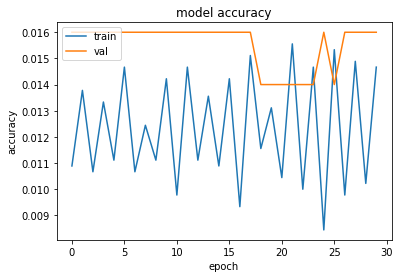

In [20]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()


#Show top 10 tweet recommendations to a user

In [21]:
tweet_df = pd.DataFrame([tweet for tweet in data.columns])
tweet_df.columns = ['tweetId']

# Let us get a user and see the top recommendations.
user_id = df.userId.sample(1).iloc[0]
tweets_watched_by_user = df[df.userId == user_id]
tweets_not_watched = tweet_df[
    ~tweet_df["tweetId"].isin(tweets_watched_by_user.tweetId.values)
]["tweetId"]
tweets_not_watched = list(
    set(tweets_not_watched).intersection(set(tweet2tweet_encoded.keys()))
)
tweets_not_watched = [[tweet2tweet_encoded.get(x)] for x in tweets_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_tweet_array = np.hstack(
    ([[user_encoder]] * len(tweets_not_watched), tweets_not_watched)
)
ratings = model.predict(user_tweet_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_tweets_ids = [
    tweet_encoded2tweet.get(tweets_not_watched[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Tweets with high ratings from user")
print("----" * 8)
top_tweets_user = (
    tweets_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .tweetId.values
)
tweet_df_rows = tweet_df[tweet_df["tweetId"].isin(top_tweets_user)]
for row in tweet_df_rows.tweetId:
    print(row)

print("----" * 8)
print("Top 10 tweets recommendations")
print("----" * 8)
recommended_tweets = tweet_df[tweet_df["tweetId"].isin(recommended_tweets_ids)]
for row in recommended_tweets.tweetId:
    print(row)

Showing recommendations for user: user18
Tweets with high ratings from user
--------------------------------
tweet57
tweet92
tweet108
tweet159
tweet208
--------------------------------
Top 10 tweets recommendations
--------------------------------
tweet70
tweet80
tweet89
tweet119
tweet120
tweet202
tweet223
tweet238
tweet239
tweet246
